# Praca domowa z AutoML

## Wstęp

In [1]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import math
import re
import warnings
from pandas.api.types import is_numeric_dtype

In [2]:
diabetic_df = pd.read_csv('diabetic_data.csv')

In [3]:
diabetic_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
weight,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3
admission_source_id,1,7,7,7,7,2,2,7,4,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12


In [4]:
diabetic_df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

Dane na których będę pracował to dane medyczne. Za pomocą danych będę chciał określić czy pacjent zostanie przyjęty w ciągu 30 dni czy nie.

In [5]:
diabetic_df['readmitted'] = diabetic_df['readmitted'].apply(lambda x: 0 if (x == '<30') else 1)

## Czyszczenie danych

Braki danych oznaczone zostały za pomocą '?' poza kolumną gender gdzie użyto 'Unknown/Invalid'. Zamienię te wartości na None i sprawdzę jaki procent w każdej kolumnie stanowią brakujące dane.

In [6]:
diabetic_df.replace({'Unknown/Invalid' : None, '?' : None}, inplace=True)
diabetic_df.isnull().mean() * 100

encounter_id                 0.000000
patient_nbr                  0.000000
race                         2.233555
gender                       0.002948
age                          0.000000
weight                      96.858479
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  39.557416
medical_specialty           49.082208
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.020636
diag_2                       0.351787
diag_3                       1.398306
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide 

Pozbędę się kolumn 'weight','payer_code', 'medical_specialty' - za dużo brakujących danych.

In [7]:
diabetic_df = diabetic_df.drop(['weight','payer_code', 'medical_specialty'], axis = 1)

In [8]:
diabetic_df.dropna(inplace=True)

Kolumna 'encounter_id' opisuje unikalne id spotkania pacjenta i nie wnosi żadnych wartościowych informacji dlatego się jej pozbędę. 

In [9]:
diabetic_df = diabetic_df.drop(['encounter_id'], axis = 1)

Niektórzy pacjenci trafili więcej niż raz do szpitala. Takie zdarzenia nie są oczywiście niezależne dlatego wziąłem pod uwagę tylko pierwsze ze spotkań, pozostałe usunąłem. Następnie pozbyłem się kolumny patient_nbr która nie niesie ze sobą już żadnych wartościowych informacji.

In [10]:
diabetic_df.drop_duplicates(subset=['patient_nbr'], inplace=True)
diabetic_df.drop(['patient_nbr'], axis = 1, inplace=True)

Usunąłem również kolumny 'diag_2' oraz 'diag_3', które opisują dodatkowe diagnozy, pozostawiając tylko pierwszą, główną diagnozę która ma największe znaczenie.

In [11]:
diabetic_df = diabetic_df.drop(['diag_2', 'diag_3'], axis = 1)

Muszę pozbyć się także pacjentów którzy zmarli lub są w hospicjum gdyż wiem na pewno że nie trafią już do szpitala. Są to pacjenci z discharge_disposition_id 13-14 i 19-21.

In [12]:
diabetic_df.drop(diabetic_df[(diabetic_df.discharge_disposition_id == 13) |
                            (diabetic_df.discharge_disposition_id == 14) |
                            (diabetic_df.discharge_disposition_id == 19) |
                            (diabetic_df.discharge_disposition_id == 20) |
                            (diabetic_df.discharge_disposition_id == 21)].index, inplace=True)

In [13]:
diabetic_df.shape

(68165, 43)

Liczba rekordów zmalała do 68165.

## Grupowanie zmiennych kategorycznych

In [14]:
diabetic_df.head(10).T

,1,2,3,4,5,6,7,8,9,10
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,AfricanAmerican
gender,Female,Female,Male,Male,Male,Male,Male,Female,Female,Female
age,[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100),[40-50)
admission_type_id,1,1,1,1,2,3,1,2,3,1
discharge_disposition_id,1,1,1,1,1,1,1,1,3,1
admission_source_id,7,7,7,7,2,2,7,4,4,7
time_in_hospital,3,2,2,1,3,4,5,13,12,9
num_lab_procedures,59,11,44,51,31,70,73,68,33,47
num_procedures,0,5,1,0,6,1,0,2,3,2
num_medications,18,13,16,8,16,21,12,28,18,17


In [15]:
diabetic_df.shape

(68165, 43)

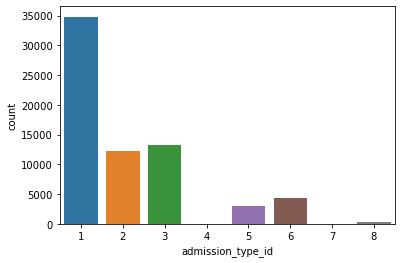

In [16]:
sns.countplot(data=diabetic_df, x='admission_type_id')
plt.show()

Zmienna 'admision_type_id' opisuje rodzaj przyjęcia pacjenta. Poszczególne id oznaczają:
- 1 : Emergency
- 2 : Urgent
- 3 : Elective
- 4 : Newborn
- 5 : Not Available
- 6 : NULL
- 7 : Trauma Center
- 8 : Not Mapped
Postanowiłem zmniejszyć liczbę kategorii. 'Emergency' i 'Urgent' znaczą praktycznie to samo dlatego połączyłem je razem, tak samo połączyłem kategorie 4-8, ponieważ id o numerach 4,7,8 prawie nie występują a 5 i 6 rozumiem jako brak danych.

In [17]:
diabetic_df['admission_type_id'] = diabetic_df['admission_type_id'].apply(lambda x: 'Urgent' if (x == 1 or x == 2) else ('Elective' if x == 3 else 'Other'))

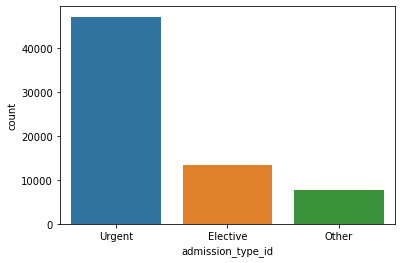

In [18]:
sns.countplot(data=diabetic_df, x='admission_type_id')
plt.show()

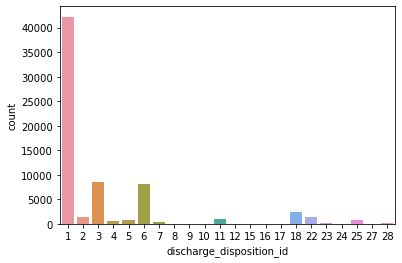

In [19]:
sns.countplot(data=diabetic_df, x='discharge_disposition_id')
plt.show()

Zmienna 'discharge_disposition_id' opisuje rodzaj wypisania ze szpitala. Ponieważ kategorii jest dużo i 'odesłanie do domu' przeważa znacząco nad innymi pogrupowałem je w dwie główne: 'odesłanie do domu' i 'inny'.

In [20]:
diabetic_df['discharge_disposition_id'] = diabetic_df['discharge_disposition_id'].apply(lambda x: 'Discharged_to_home' if (x == 1 or x == 6 or x == 8) else 'Other')

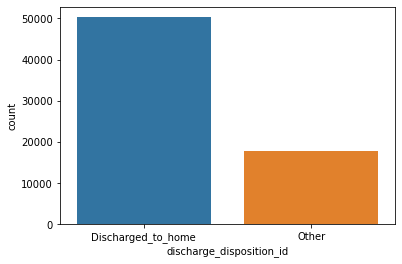

In [21]:
sns.countplot(data=diabetic_df, x='discharge_disposition_id')
plt.show()

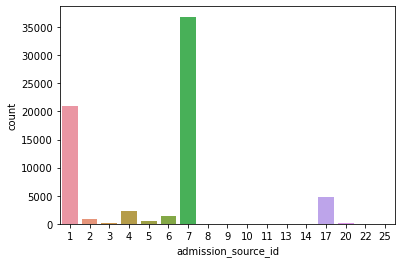

In [22]:
sns.countplot(data=diabetic_df, x='admission_source_id')
plt.show()

Zmienna 'admission_source_id' opisuje rodzaj przyjęcia do szpitala. Tak jak poprzednio zmniejszyłem liczbę kategorii, tym razem do trzech głównych.

In [23]:
diabetic_df['admission_source_id'] = diabetic_df['admission_source_id'].apply(lambda x: 'Referral' if (x == 1 or x == 2 or x == 2) else ('Emergency_room' if x == 7 else 'Other'))

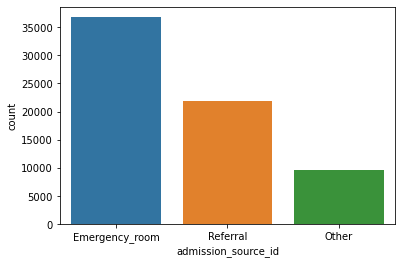

In [24]:
sns.countplot(data=diabetic_df, x='admission_source_id')
plt.show()

## Przekształcenie niektórych zmiennych

Zmienna wiek występuje w ramce danych jako przedziały o szerokości 10 lat. Jednak jako zmienna kategoryczna nie występuje porządek między  Założyłem że mediana wieku pacjentów w każdym przedziale jest równa środkowi przedziału dlatego zastąpiłem każdy przedział jego środkiem.

In [25]:
diabetic_df['age'] = diabetic_df['age'].apply(lambda x: np.sum([int(s) for s in re.findall(r'\b\d+\b', str(x))])//2)

In [26]:
diabetic_df.columns[17:42]

Index(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')

Kolumny 17:40 opisują sposób dawkowania różnych substancji/leków. Przekształciłem te kolumny tak aby przyjmowały tylko 0 i 1 aby nie wprowadzać mnóstwa dodatkowych kolumn przy one-hot encodingu. 0 oznacza że nie zmienił się sposób dawkowania leku a 1 że się zmienił (nie ważne czy zwiększono czy zmniejszono dawkę).

In [27]:
for col in diabetic_df.columns[17:42]:
    diabetic_df[col] = diabetic_df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

Przetłumaczyłem id diagnozy na odpowiadające im kategorie.

In [28]:
def translate_diagnosis(x):
    if (((x >= 390) & (x <= 459)) | (x == 785)):
        return "Circulatory"
    elif (((x >= 460) & (x <= 519)) | (x == 786)):
        return "Respiratory"
    elif (((x >= 520) & (x <= 579)) | (x == 787)):
        return "Digestive" 
    elif (math.floor(x) == 250):
        return "Diabetes" 
    elif (((x >= 800) & (x <= 999))):
        return "Injury" 
    elif (((x >= 710) & (x <= 739))):
        return "Musculoskeletal" 
    elif (((x >= 580) & (x <= 629)) | (x == 788)):
        return "Genitourinary" 
    elif (((x >= 140) & (x <= 239))):
        return "Neoplasms" 
    else:
        return "Other" 

In [29]:
diabetic_df['diag_1'] = pd.to_numeric(diabetic_df['diag_1'], errors='coerce').fillna(0)
diabetic_df['diag_1'] = diabetic_df['diag_1'].apply(translate_diagnosis)

## Encoding pozostałych zmiennych kategorycznych

Zacznijmy od zmiennej 'gender'. Przyjmuje ona tylko 2 wartości. W tym przypadku łatwo możemy zamienić kobietę na 0 i mężczyznę na 1.

In [30]:
diabetic_df['gender'] = diabetic_df['gender'].apply(lambda x: 0 if (x == 'Female') else 1)

Zmienna 'discharge_disposition_id' również przyjmuje tylko 2 wartości. W jej przypadku postąpię podobnie.

In [31]:
diabetic_df['discharge_disposition_id'] = diabetic_df['discharge_disposition_id'].apply(lambda x: 1 if (x == 'Discharged_to_home') else 0)

Stworzyłem funkcję która pozwoli mi dokonać one-hot encdingu na pozostałych zmiennych kategorycznych.

In [32]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [33]:
for col in diabetic_df:
    if not (is_numeric_dtype(diabetic_df[col])):
        diabetic_df = encode_and_bind(diabetic_df, col)

Na koniec sprawdziłem czy są jakieś zmienne które przyjmują tylko 1 wartość, nie niosą one żadnych informacji dlatego się ich pozbyłem.

In [34]:
diabetic_df.nunique()

gender                        2
age                          10
discharge_disposition_id      2
time_in_hospital             14
num_lab_procedures          116
                           ... 
max_glu_serum_Norm            2
A1Cresult_>7                  2
A1Cresult_>8                  2
A1Cresult_None                2
A1Cresult_Norm                2
Length: 65, dtype: int64

In [35]:
for col in diabetic_df:
    if (diabetic_df[col].nunique() == 1):
        diabetic_df.drop([col], axis = 1, inplace=True)

## Analiza jednowymiarowa

In [36]:
df2 = diabetic_df[["age", "time_in_hospital", "num_lab_procedures", "num_procedures", "num_medications", "number_emergency", "number_outpatient","number_inpatient","number_diagnoses"]]

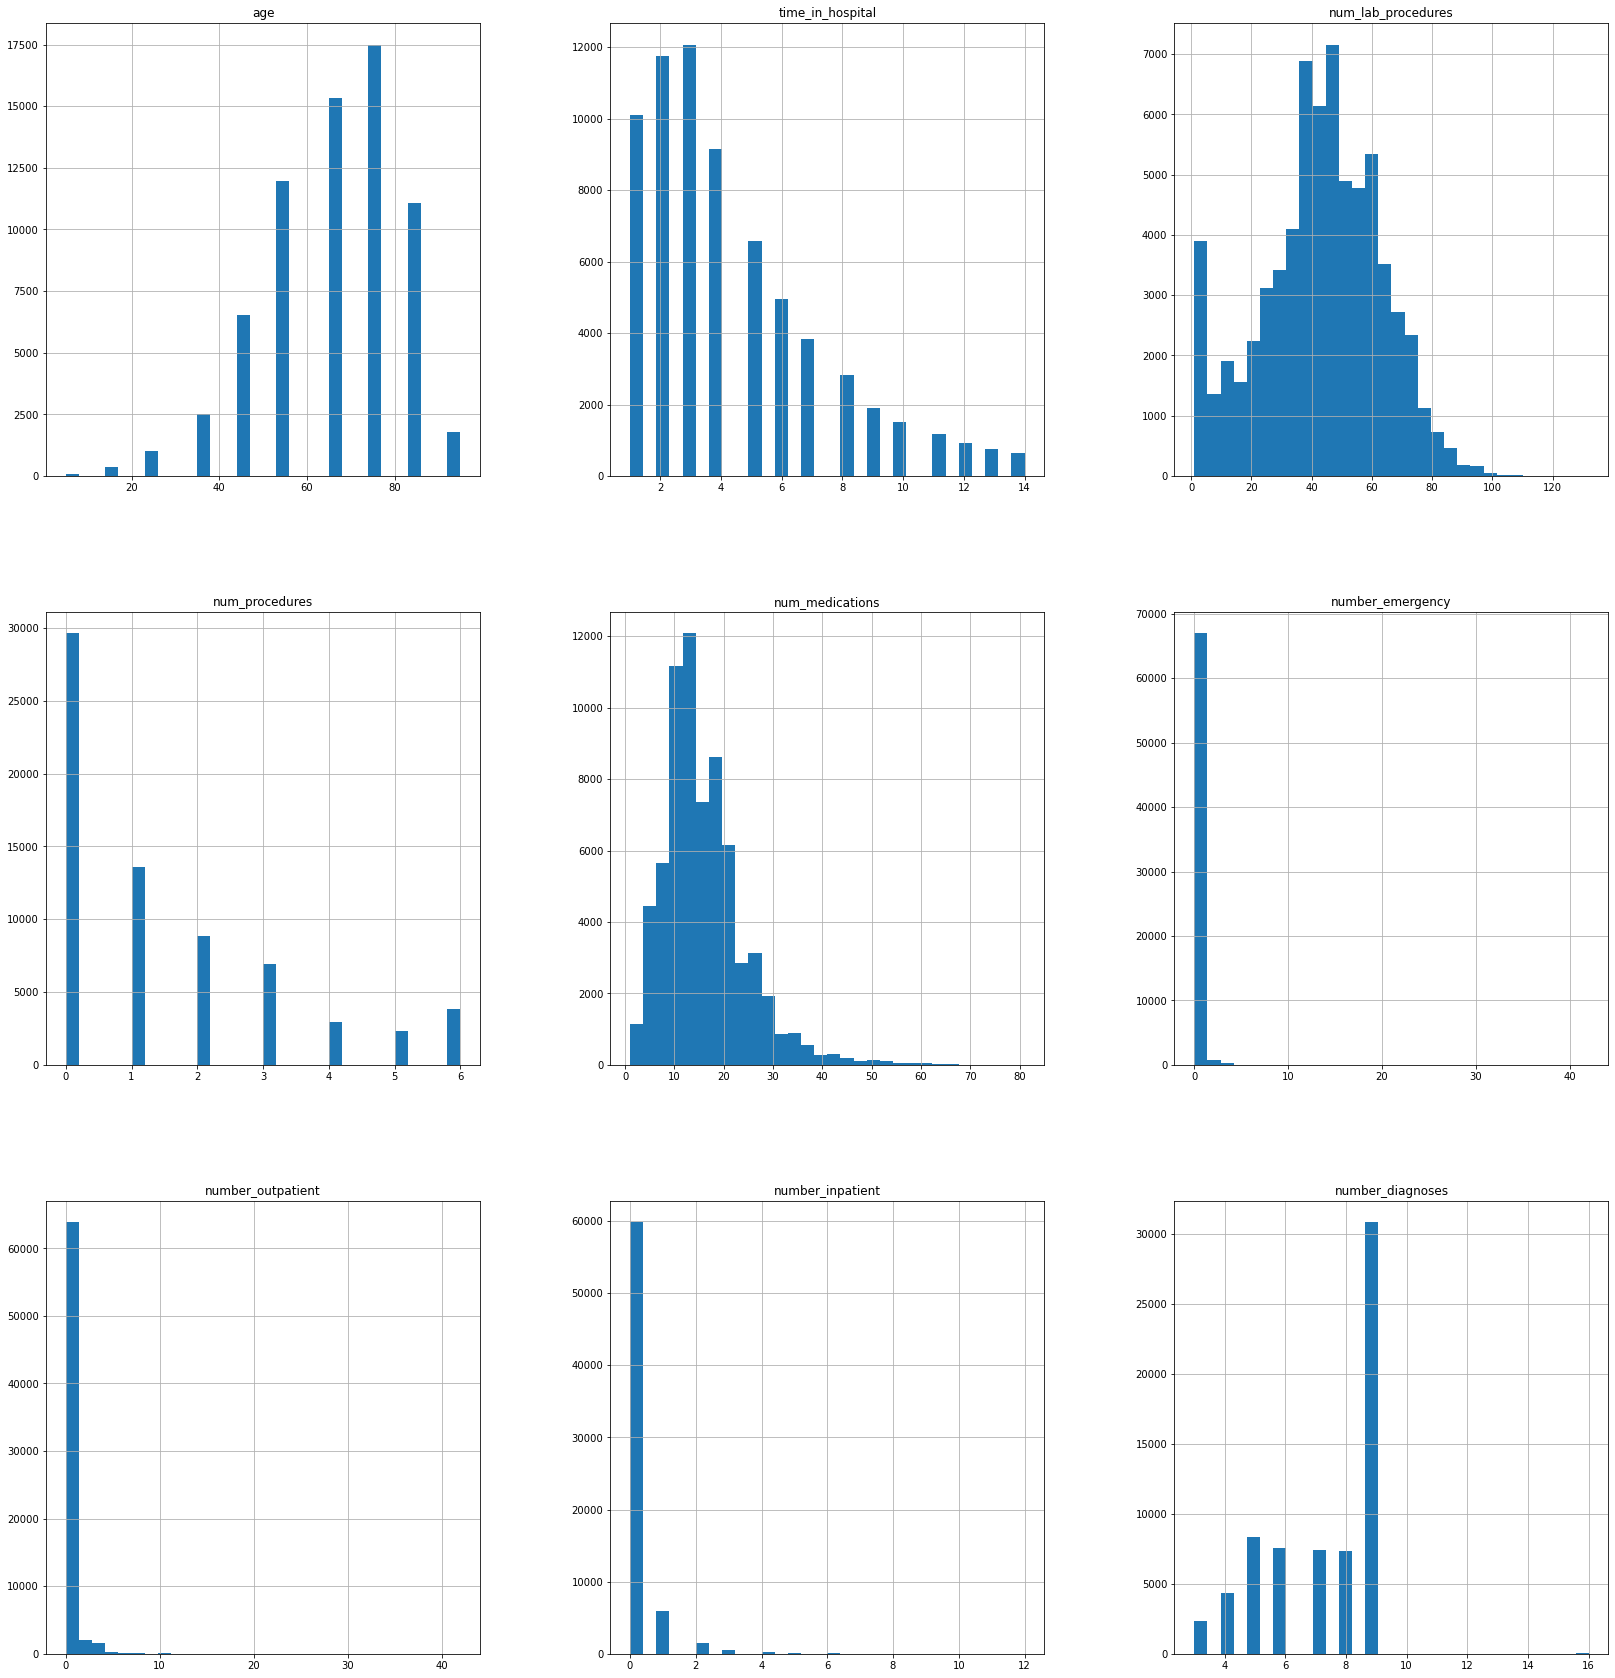

In [37]:
df2.hist(bins = 30, figsize = (28,30))
plt.show()

Wnioski: zmienne num_lab_procedures, num_medications i time_in_hospital wyglądają jak rozkład skośny dodatnio, za to age jak rozkład skośny ujemnie.

## Analiza wielowymiarowa

### Macierz korelacji

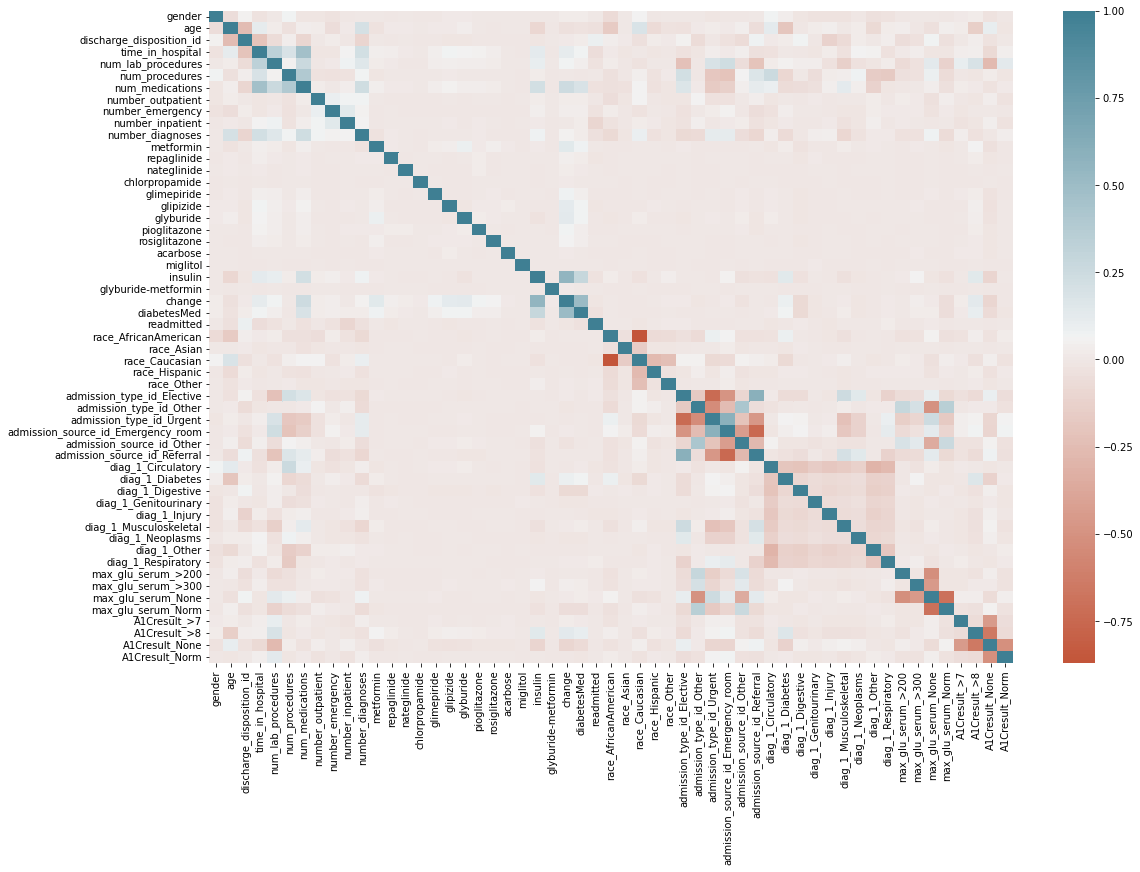

In [38]:
matrix = diabetic_df.corr()
plt.figure(figsize=(18, 12))
sns.heatmap(matrix, cmap = sns.diverging_palette(20, 220, n=200))

plt.show()

In [39]:
diabetic_df.corr().unstack().sort_values(ascending=False).drop_duplicates().head(10)

gender                              gender                        1.000000
admission_source_id_Referral        admission_type_id_Elective    0.599306
admission_source_id_Emergency_room  admission_type_id_Urgent      0.593753
insulin                             change                        0.559583
diabetesMed                         change                        0.508615
time_in_hospital                    num_medications               0.467186
admission_source_id_Other           admission_type_id_Other       0.429098
num_procedures                      num_medications               0.400761
admission_type_id_Other             max_glu_serum_Norm            0.351626
time_in_hospital                    num_lab_procedures            0.329283
dtype: float64

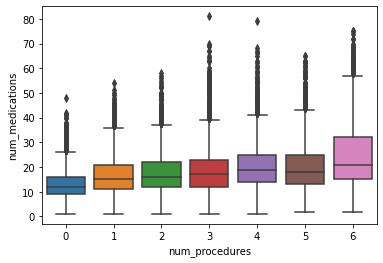

In [40]:
sns.boxplot(data=diabetic_df, x="num_procedures", y="num_medications")
plt.show()

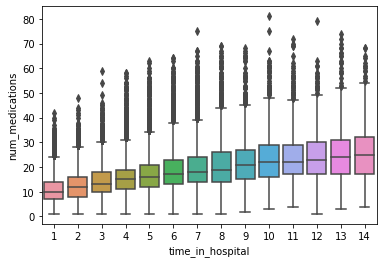

In [41]:
sns.boxplot(data=diabetic_df, x="time_in_hospital", y="num_medications")
plt.show()

Wnioski:
Możemy zaobserwować w prosty sposób tylko dość oczywiste zależności:
 - im dłuższy czas w szpitalu tym więcej leków przyjął pacjent
 - także im więcej procedur przeszedł tym więcej leków przyjął
 - 'change' (zmiana w dawkowaniu leków na cukrzycę) koreluje ze zmianą dawkowania insuliny i 'diabetesMed' (przypisanie leków na cukrzycę)
 - skierowanie lekarskie koreluje z nieobowiązkową wizytą a wypadek z nagłą.